In [1]:
# Import the datamodule
from anomalib.data import Folder

# Create the datamodule
datamodule = Folder(
    name="data",
    root="/mnt/data/",
    normal_dir="input_train",
    task="classification",
    num_workers=2,
    # See this !!!!!
    image_size=(64, 64)
)

# Setup the datamodule
datamodule.setup()

# Access the datasets
train_dataset = datamodule.train_data
train_dataloader = datamodule.train_dataloader()

INFO:anomalib.data.base.datamodule:No normal test images found. Sampling from training set using a split ratio of 0.20


In [ ]:
i, train_data = next(enumerate(datamodule.train_dataloader()))
print(train_data.keys())
print(train_data["image"].shape)

dict_keys(['image_path', 'label', 'image'])


In [2]:
# Import the model and engine
from ollama._client import _encode_image
from anomalib.models import Patchcore, Padim, Fre
from anomalib.engine import Engine
from anomalib.deploy import ExportType

# Create the model and engine
model = Padim()
engine = Engine()

# Train a Patchcore model on the given datamodule
engine.train(datamodule=datamodule, model=model)

/mnt/data/.conda/envs/anomaly/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
INFO:anomalib.models.components.base.anomaly_module:Initializing Padim model.
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet18.a1_in1k)
INFO:timm.models._hub:[timm/resnet18.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (fc.weight, fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
INFO

Training: |          | 0/? [00:00<?, ?it/s]

/mnt/data/.conda/envs/anomaly/lib/python3.11/site-packages/lightning/pytorch/loops/optimization/automatic.py:134: `training_step` returned `None`. If this was on purpose, ignore this warning...


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:anomalib.models.image.padim.lightning_model:Aggregating the embedding extracted from the training set.
INFO:anomalib.models.image.padim.lightning_model:Fitting a Gaussian to the embedding collected from the training set.
/mnt/data/.conda/envs/anomaly/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for all thresholds.
  warnings.warn(*args, **kwargs)  # noqa: B028
/mnt/data/.conda/envs/anomaly/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:anomalib.callbacks.timer:Training took 46.33 seconds


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:anomalib.callbacks.timer:Testing took 100.68318367004395 seconds
Throughput (batch_size=32) : 8.22381623045908 FPS


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │            0.0            │
│       image_F1Score       │            0.0            │
└───────────────────────────┴───────────────────────────┘

In [13]:
# 7 - export torch weights
print("Export weights...")
path_export_weights = engine.export(export_type=ExportType.TORCH,
                                    model=model, 
                                    export_root="/mnt/data/ens100_joao/anomaly_models")

print("path_export_weights: ", path_export_weights)

INFO:root:Exported model to /mnt/data/ens100_joao/anomaly_models/weights/torch/model.pt


Export weights...
path_export_weights:  /mnt/data/ens100_joao/anomaly_models/weights/torch/model.pt


In [8]:
import matplotlib.pyplot as plt
import numpy as np

def img_is_color(img):
    if len(img.shape) == 3:
        # Check the color channels to see if they're all the same.
        c1, c2, c3 = img[:, :, 0], img[:, :, 1], img[:, :, 2]
        if (c1 == c2).all() and (c2 == c3).all():
            return True

    return False

def show_image_list(list_images, path_image, list_titles=None, list_cmaps=None, grid=True, num_cols=2, figsize=(20, 10),
                    title_fontsize=30):
    '''
    Shows a grid of images, where each image is a Numpy array. The images can be either
    RGB or grayscale.

    Parameters:
    ----------
    images: list
        List of the images to be displayed.
    list_titles: list or None
        Optional list of titles to be shown for each image.
    list_cmaps: list or None
        Optional list of cmap values for each image. If None, then cmap will be
        automatically inferred.
    grid: boolean
        If True, show a grid over each image
    num_cols: int
        Number of columns to show.
    figsize: tuple of width, height
        Value to be passed to pyplot.figure()
    title_fontsize: int
        Value to be passed to set_title().
    '''

    assert isinstance(list_images, list)
    assert len(list_images) > 0
    assert isinstance(list_images[0], np.ndarray)

    if list_titles is not None:
        assert isinstance(list_titles, list)
        assert len(list_images) == len(list_titles), '%d imgs != %d titles' % (len(list_images), len(list_titles))

    if list_cmaps is not None:
        assert isinstance(list_cmaps, list)
        assert len(list_images) == len(list_cmaps), '%d imgs != %d cmaps' % (len(list_images), len(list_cmaps))

    num_images = len(list_images)
    num_cols = min(num_images, num_cols)
    num_rows = int(num_images / num_cols) + (1 if num_images % num_cols != 0 else 0)

    # Create a grid of subplots.
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    # Create list of axes for easy iteration.
    if isinstance(axes, np.ndarray):
        list_axes = list(axes.flat)
    else:
        list_axes = [axes]

    for i in range(num_images):
        img = list_images[i]
        title = list_titles[i] if list_titles is not None else 'Image %d' % (i)
        cmap = list_cmaps[i] if list_cmaps is not None else (None if img_is_color(img) else 'gray')

        list_axes[i].imshow(img, cmap=cmap)
        list_axes[i].set_title(title, fontsize=title_fontsize)
        list_axes[i].grid(grid)

    for i in range(num_images, len(list_axes)):
        list_axes[i].set_visible(False)

    fig.tight_layout()
    plt.savefig(path_image)
    _ = plt.show()

In [1]:
from anomalib.deploy import TorchInferencer
import torch
from anomalib.models import Patchcore, Padim, Fre
from anomalib.deploy.export import InferenceModel

# Allowlist the InferenceModel class (only if you trust the model file)
#torch.serialization.safe_globals([InferenceModel])
#torch.serialization.safe_globals([Padim])

# 1 - instantiate the TorchInferencer
inferencer = TorchInferencer(path="/mnt/data/ens100_joao/anomaly_models/weights/torch/model.pt",
                             device="cpu")

/mnt/data/.conda/envs/anomaly/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/mnt/data/.conda/envs/anomaly/lib/python3.11/site-packages/anomalib/deploy/inferencers/torch_inferencer.py:109: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicit

Abnormal - pred_score: 1.0000


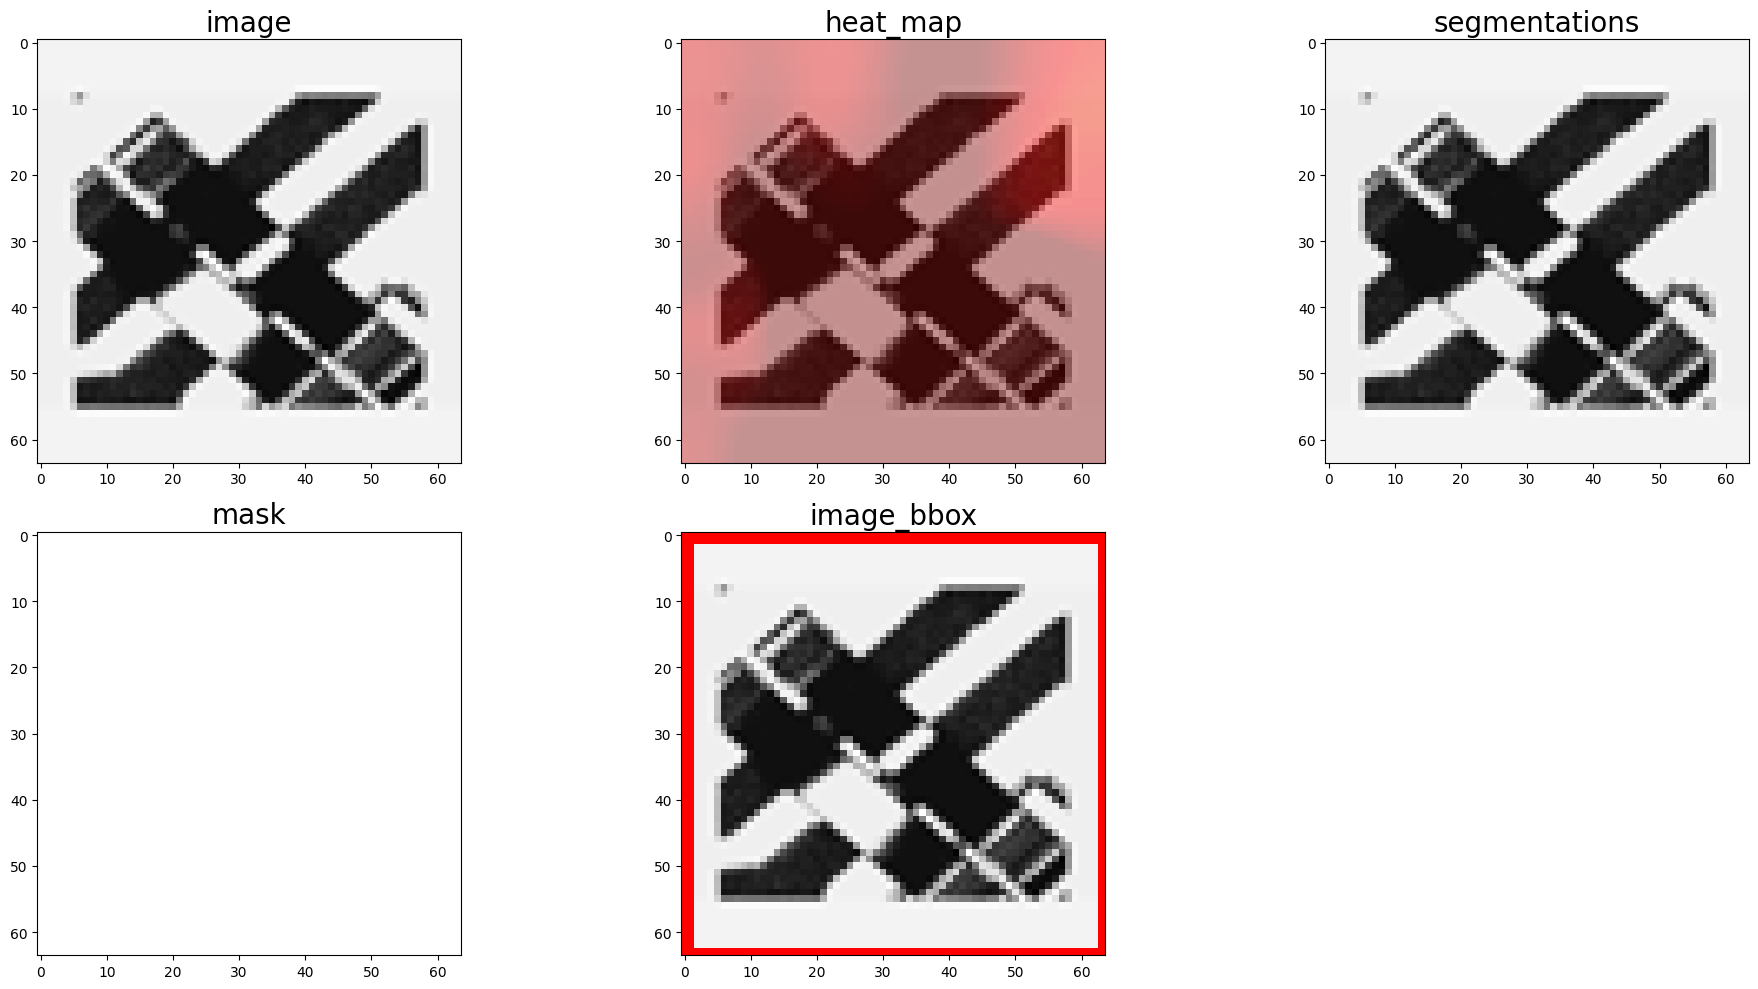

In [12]:
import sys
from PIL import Image
from anomalib.deploy import TorchInferencer
import numpy as np
import cv2
from torch import as_tensor
from torchvision.transforms.v2.functional import to_dtype, to_image
import torch

# 1 - instantiate the TorchInferencer
inferencer = TorchInferencer(path="/mnt/data/ens100_joao/anomaly_models/weights/torch/model.pt",
                             device="cpu")

# 2 - load and preprocess the image
image = Image.open("/mnt/data/input_test/0d427e8620451a4b8d4450024e54ebd942b55e8c5e21b79af50b5b42d8cbb5d8.png").convert("RGB")
image = image.resize((64, 64))
image = to_dtype(to_image(image), torch.float32, scale=True) if as_tensor else np.array(image) / 255.0

# 3 - execute the prediction
result = inferencer.predict(image=image)

# result.pred_score gives the score to be anomalous
if result.pred_label == 0:
    normal_score = 1 - result.pred_score
    print("Normal - pred_score: {:.4f}".format(normal_score))
else:
    print("Abnormal - pred_score: {:.4f}".format(result.pred_score))

# build the bounding box from the mask
image_bbox = result.image.copy()
# Find the contours of the white mask
contours, _ = cv2.findContours(result.pred_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Create the bbox around the white contours
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(image_bbox, (x, y), (x+w, y+h), (255, 0, 0), 2)

# stack three time the mask to simulate the three colour channels
mask = cv2.merge((result.pred_mask,result.pred_mask,result.pred_mask))

show_image_list(list_images=[result.image, result.heat_map, result.segmentations, mask, image_bbox],
                list_titles=['image', 'heat_map', 'segmentations', 'mask', 'image_bbox'],
                num_cols=3,
                figsize=(20, 10),
                grid=False,
                title_fontsize=20,
                path_image="/mnt/data/ens100_joao/anomaly_models")

In [16]:
import os
import pandas as pd
from PIL import Image
import numpy as np
import cv2
import torch
from torchvision.transforms.v2.functional import to_dtype, to_image
from anomalib.deploy import TorchInferencer

# 1 - Instantiate the TorchInferencer
inferencer = TorchInferencer(
    path="/mnt/data/ens100_joao/anomaly_models/weights/torch/model.pt",
    device="cpu"
)

# Directory containing the images
input_dir = "/mnt/data/input_test"
results = []  # List to store each image's result

# 2 - Loop through each image in the directory
for filename in os.listdir(input_dir):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
        image_path = os.path.join(input_dir, filename)
        
        # Load and preprocess the image
        image = Image.open(image_path).convert("RGB")
        image = image.resize((64, 64))
        # Convert image to tensor in float32 format (scaled between 0 and 1)
        image = to_dtype(to_image(image), torch.float32, scale=True)
        
        # 3 - Execute prediction
        result = inferencer.predict(image=image)
        
        # Calculate anomaly score based on prediction label
        if result.pred_label == 0:
            # When the label indicates normal, we invert the anomaly score
            anomaly_score = 1 - result.pred_score
            prediction = "Normal"
        else:
            anomaly_score = result.pred_score
            prediction = "Abnormal"
        
        # Append the results to the list
        results.append({
            "filename": filename,
            "anomaly_score": anomaly_score,
            "prediction": prediction
        })

# 4 - Create a DataFrame from the results
df = pd.DataFrame(results)
print(df)

# Optionally, save the DataFrame to a CSV file
df.to_csv("/mnt/data/ens100_JOAO/anomaly_models/anomaly_scores.csv", index=False)


/mnt/data/.conda/envs/anomaly/lib/python3.11/site-packages/anomalib/deploy/inferencers/torch_inferencer.py:109: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.lo

                                               filename  anomaly_score  \
0     631e2104780e65748b3f809ed808158f560aebd735f2e1...            1.0   
1     b5e89885021e7e45129af5e2a43edd5938cf6160d1f3a6...            1.0   
2     6a78aa5c3c6f25afaf54c9b7f66c552b74ed45a471610a...            1.0   
3     8f4630c84d1ffe98ddcc419dbc01b27860f68f48f1507f...            1.0   
4     2fa2013d9f771e5e0033561bd1e5bbd34a5b256b2c1b65...            1.0   
...                                                 ...            ...   
1050  6f050e6e6d0d683542bd778f2fd2245967a9f510160614...            1.0   
1051  6738b0541d54a4f5b183d2612f3b2e6e42d6a678aba702...            1.0   
1052  4774ea626d257b9701b14d41b892e3b8100c6628beef30...            1.0   
1053  90e9bfe8c3af327fb6649832ba7cf6444fc1c0e07a428a...            1.0   
1054  3c22da2cb29650e37b77993cd6e25561974f83642dc595...            1.0   

     prediction  
0      Abnormal  
1      Abnormal  
2      Abnormal  
3      Abnormal  
4      Abnormal  
...

OSError: Cannot save file into a non-existent directory: '/mnt/data/ens100_JOAO/anomaly_models'

In [17]:
df.head(50)

,filename,anomaly_score,prediction
0,631e2104780e65748b3f809ed808158f560aebd735f2e1...,1.0,Abnormal
1,b5e89885021e7e45129af5e2a43edd5938cf6160d1f3a6...,1.0,Abnormal
2,6a78aa5c3c6f25afaf54c9b7f66c552b74ed45a471610a...,1.0,Abnormal
3,8f4630c84d1ffe98ddcc419dbc01b27860f68f48f1507f...,1.0,Abnormal
4,2fa2013d9f771e5e0033561bd1e5bbd34a5b256b2c1b65...,1.0,Abnormal
5,512e6ee4349f29be0c59498ffa2474c62ca2ab0b7e86c8...,1.0,Abnormal
6,48dc067735707b56ef419f6193a6380fdaf504abc5e78f...,1.0,Abnormal
7,240038dd9eb209999db364480141b931380eff8f1c99e8...,1.0,Abnormal
8,82f9c196acfd9f1678618871e5b351a9cc8003a9d429a4...,1.0,Abnormal
9,775e64d209a6e9f3ec7a2ecd655b971fca97caefa95f80...,1.0,Abnormal
